In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from lightai.core import *
from lightai.train import *
import cv2
from torch.utils.data import DataLoader
from src.dataset import *
from src.file_op import *
from src.metric import *
from src.tsfm import *
from src.utils import *
from albumentations import *
from glob import glob
from imagehash import phash

In [3]:
df = pd.read_csv('inputs/full.csv')

In [4]:
def cal_hash(img_id):
    img = make_rgb(img_id, "inputs/512_train/")
    img = Image.fromarray(img)
    return phash(img)

In [5]:
%%time
hashs = []
with ProcessPoolExecutor(6) as e:
    for h in e.map(cal_hash, df['Id']):
        hashs.append(h)

CPU times: user 19 s, sys: 2.67 s, total: 21.7 s
Wall time: 2min 21s


In [38]:
def test():
    same = []
    total = len(hashs)
    for i in range(364, total-1):
        for j in range(i+1, total):
            if (hashs[i].hash!=hashs[j].hash).sum() == 13:
                print(i,j)
                same.append((i,j))
                if len(same) == 10:
                    return same

In [39]:
same=test()

KeyboardInterrupt: 

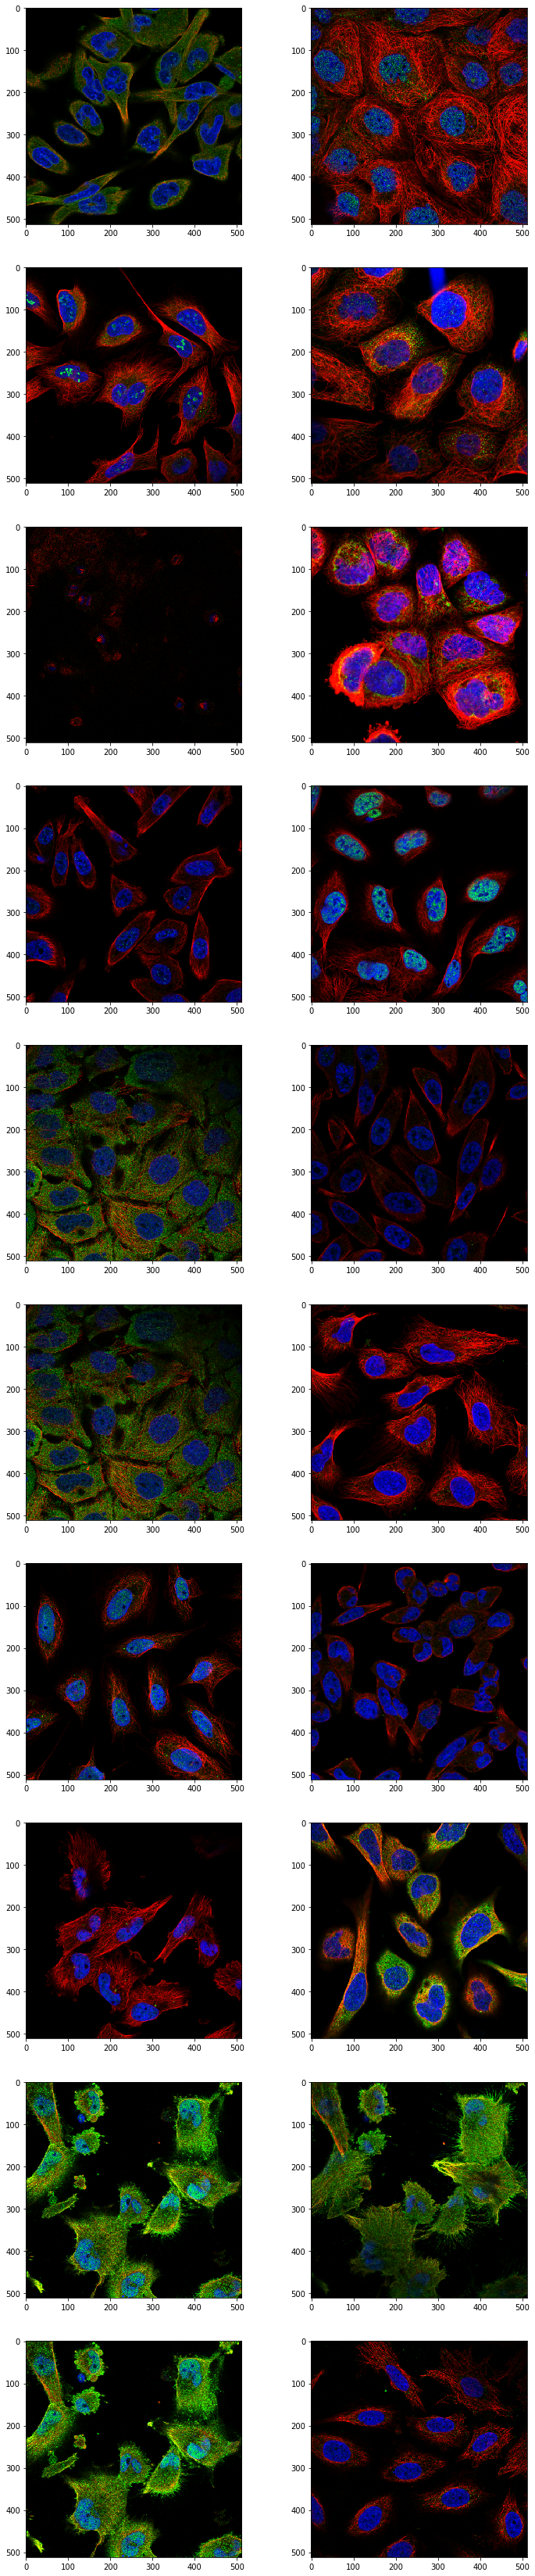

In [37]:
_, axes = plt.subplots(10, 2, figsize=(12,6*10))
for row, (i,j) in zip(axes,same):
    a = make_rgb(df.Id[i], 'inputs/512_train/')
    b = make_rgb(df.Id[j], 'inputs/512_train/')
    row[0].imshow(a)
    row[1].imshow(b)

In [42]:
def f(i):
    a = []
    b = []
    for j in range(i+1, total):
        if (hashs[i].hash!=hashs[j].hash).sum() <= 12:
            a.append(i)
            b.append(j)
    return a,b

In [151]:
with open('hashs', 'rb') as f:
    hashs = pickle.load(f)

In [170]:
with open('same', 'rb') as f:
    same_i, same_j = pickle.load(f)

In [41]:
len(same_i)

24607

In [43]:
same_i = []
same_j = []

In [44]:
%%time
total = len(hashs)
with ProcessPoolExecutor(6) as e:
    for i,j in progress_bar(e.map(f, range(total-1)), total=total-1):
        same_i.extend(i)
        same_j.extend(j)

CPU times: user 31.2 s, sys: 4.22 s, total: 35.4 s
Wall time: 38min 17s


In [171]:
len(same_i)

24476

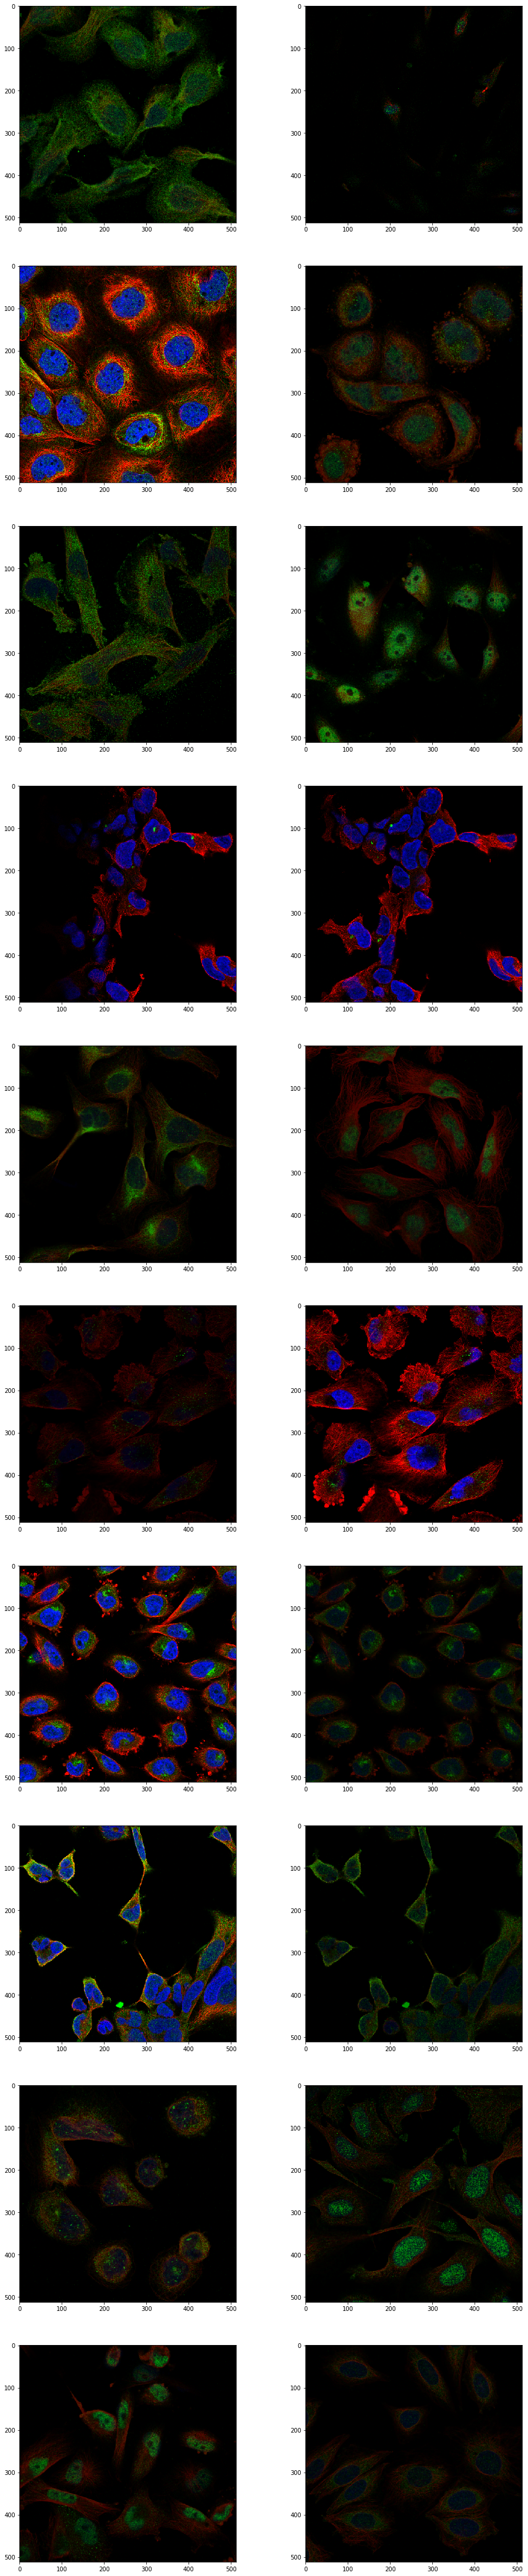

In [61]:
idx = np.random.randint(0, len(same_i), size=10)
_, axes = plt.subplots(10, 2, figsize=(16,16*5))
for row, i, j in zip(axes, same_i[idx], same_j[idx]):
    row[0].imshow(make_rgb(df.iloc[i].Id))
    row[1].imshow(make_rgb(df.iloc[j].Id))

In [172]:
clusters = {}

In [173]:
%%time
for i, j in zip(same_i, same_j):
    c = clusters.get(i)
    d = clusters.get(j)
    if c is None and d is None:
        s = {i,j}
        clusters[i] = s
        clusters[j] = s
    elif c is None:
        d.add(i)
        clusters[i] = d
    elif d is None:
        c.add(j)
        clusters[j] = c
    else:
        c.update(d)
        for v in d:
            clusters[v] = c

CPU times: user 13.3 ms, sys: 0 ns, total: 13.3 ms
Wall time: 13.3 ms


In [174]:
for key, value in clusters.items():
    clusters[key] = frozenset(value)

In [175]:
final = set()

In [176]:
for value in clusters.values():
    final.add(value)

In [177]:
final = list(final)

In [143]:
with open('final', 'rb') as f:
    final = pickle.load(f)

In [178]:
import random
random.shuffle(final)

In [179]:
cls_sz = []
for c in range(28):
    cls_sz.append(len(get_idx_from_target(df, c)))

In [180]:
n_fold = 5

In [181]:
fold_cls_sz = []
for fold in range(n_fold):
    each = []
    for sz in cls_sz:
        each.append(sz//n_fold)
    fold_cls_sz.append(each)

In [182]:
same_folds = []
for fold in range(n_fold):
    same_folds.append([])

In [183]:
fold_cls_sz = np.array(fold_cls_sz)
remain_fold_cls_sz = np.array(fold_cls_sz)

In [184]:
remain_fold_cls_sz -= 5

In [185]:
for s in progress_bar(final):
    c_szs = []
    for c in range(28):
        sz = len(get_idx_from_target(df.loc[list(s)], c))
        c_szs.append(sz)
    c_szs = np.array(c_szs)
    valid_fold = np.arange(n_fold)[~((remain_fold_cls_sz < c_szs).any(axis=1))]
#     fold = valid_fold[(c_szs/remain_fold_cls_sz[valid_fold]).mean(axis=1).argmin()]
    fold_remain_percent = (c_szs/remain_fold_cls_sz[valid_fold]).mean(axis=1)
    valid_fold = valid_fold[np.where(fold_remain_percent == fold_remain_percent.min())[0]]
    fold = valid_fold[np.array([len(same_folds[fold]) for fold in valid_fold]).argmin()]
    remain_fold_cls_sz[fold] -= c_szs
    same_folds[fold].append(s)

In [186]:
for fold in same_folds:
    print(len(fold))

2787
2800
2796
2798
2800


In [207]:
for fold in same_folds:
    print(sum(len(get_idx_from_target(df.loc[list(s)], 27)) for s in fold))

9
10
9
10
10


In [124]:
for s in final:
    sz = len(get_idx_from_target(df.loc[list(s)], 10))
    if sz:
        print(sz)

2
1
1
1
1
1
1
2
1
1
2
2
2
1
2
1
2
1
1
1
1
1
1
1
2
1
1
1
1
2
1
2
2
1
1
2
1
1
1
2
2
2
1
1
1
2
2
1
2
1
3
1
1


In [192]:
remain_fold_cls_sz += 6

In [193]:
df['fold'] = -1

In [194]:
mb = master_bar(enumerate(same_folds), total=len(same_folds))
for i, fold in mb:
    for s in progress_bar(fold, parent=mb):
         df.loc[list(s), 'fold'] = i

In [195]:
for idx in progress_bar(df.index[df['fold']==-1]):
    targets = df.loc[idx, 'Target'].split()
    targets = [int(t) for t in targets]
    c_szs = np.zeros(28, dtype=np.int64)
    c_szs[targets] = 1
    valid_fold = np.arange(n_fold)[~((remain_fold_cls_sz < c_szs).any(axis=1))]
#     fold = valid_fold[(c_szs/(remain_fold_cls_sz[valid_fold]+1e-8)).mean(axis=1).argmin()]
    fold_remain_percent = (c_szs/(remain_fold_cls_sz[valid_fold]+1e-8)).mean(axis=1)
    valid_fold = valid_fold[np.where(fold_remain_percent == fold_remain_percent.min())[0]]
    fold = valid_fold[np.array([len(df[df.fold==fold]) for fold in valid_fold]).argmin()]
    remain_fold_cls_sz[fold] -= c_szs
    df.loc[idx, 'fold'] = fold

In [131]:
remain_fold_cls_sz

array([[0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1],
       [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1]])

In [197]:
for fold in range(n_fold):
    print(len(df[df.fold==fold]))

21136
21135
21135
21136
21135


In [201]:
for fold in range(n_fold):
    print(len(get_idx_from_target(df[df.fold==fold], 10)))

36
36
37
36
37


In [324]:
len(get_idx_from_target(df,25))

37366

In [202]:
assign_weight(df)

In [203]:
df.head()

Id   Target  fold    weight
0  461058de-bba9-11e8-b2ba-ac1f6b6435d0     25 4     1  0.025746
1                       57803_1259_C4_2        5     1  0.019350
2                      57667_1240_D11_7     22 5     3  0.057685
3                        42370_468_C3_2  25 0 21     4  0.016283
4                       37153_630_A10_2        0     4  0.003429

In [204]:
df.to_csv('inputs/full.csv', index=False)